In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
warnings.filterwarnings('ignore')

In [3]:
headers = {
  'Referer': 'https://stats.nba.com/players/shots-dribbles',
  'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.130 Safari/537.36',
  'x-nba-stats-origin': 'stats'
}
def get_game_logs(url="https://stats.nba.com/stats/leaguegamefinder?",PlayerOrTeam= "T",LeagueID= "00",Season= '2019-20',
                       SeasonType= 'Playoffs',TeamID= '',VsTeamID= '',PlayerID= '',GameID= '',Outcome= '',Location= '',DateFrom= '',
                       DateTo= '',VsConference= '',VsDivision= '',Conference= '',Division= '',DraftYear= '',DraftNumber= '',
                       DraftRound= '',DraftTeamID= '',RookieYear= '',YearsExperience= '',SeasonSegment= '',PORound= '',
                       StarterBench= '',GtPTS= '',GtREB= '',GtAST= '',GtSTL= '',GtBLK= '',GtOREB= '',GtDREB= '',GtDD= '',
                       GtTD= '',GtMINUTES= '',GtTOV= '',GtPF= '',GtFGM= '',GtFGA= '',GtFG_PCT= '',GtFTM= '',GtFTA= '',
                       GtFT_PCT= '',GtFG3M= '',GtFG3A= '',GtFG3_PCT= '',LtPTS= '',LtREB= '',LtAST= '',LtSTL= '',LtBLK= '',
                       LtOREB= '',LtDREB= '',LtDD= '',LtTD= '',LtMINUTES= '',LtTOV= '',LtPF= '',LtFGM= '',LtFGA= '',
                       LtFG_PCT= '',LtFTM= '',LtFTA= '',LtFT_PCT= '',LtFG3M= '',LtFG3A= '',LtFG3_PCT= '',EqPTS= '',
                       EqREB= '',EqAST= '',EqSTL= '',EqBLK= '',EqOREB= '',EqDREB= '',EqDD= '',EqTD= '',EqMINUTES= '',
                       EqTOV= '',EqPF= '',EqFGM= '',EqFGA= '',EqFG_PCT= '',EqFTM= '',EqFTA= '',EqFT_PCT= '',EqFG3M= '',
                       EqFG3A= '',EqFG3_PCT= ''):
    api_param = locals()
    payload = {}
    response = requests.request("GET",url,params=api_param,headers=headers,data = payload)
    data = response.json()
    df = pd.DataFrame(data['resultSets'][0]['rowSet'],columns=data['resultSets'][0]['headers'])
    return df

def seasons_string(start,end):
    '''
    creates a list of NBA seasons from start-end
    '''
    years = np.arange(start,end+1)
    seasons = []
    for year in years:
        string1 = str(year)
        string2 = str(year+1)
        season = '{}-{}'.format(string1,string2[-2:])
        seasons.append(season)
    return seasons

In [4]:
seasonType="Regular Season"
team_game_logs_df = get_game_logs(SeasonType=seasonType)

In [5]:
team_game_logs_df_reb = team_game_logs_df[["WL","OREB","REB","DREB","GAME_ID","TOV","TEAM_ABBREVIATION"]]
merge_df = team_game_logs_df_reb[team_game_logs_df_reb["WL"] == 'W'].merge(team_game_logs_df_reb[team_game_logs_df_reb["WL"] == 'L'],on="GAME_ID")

In [6]:
merge_df["REB_DIFF"] = merge_df["REB_x"] - merge_df["REB_y"]
merge_df["DREB_PCT_x"] = merge_df["DREB_x"] / (merge_df["DREB_x"] + merge_df["OREB_y"])
merge_df["DREB_PCT_y"] = merge_df["DREB_y"] / (merge_df["DREB_y"] + merge_df["OREB_x"])
merge_df["REB_PCT_DIFF"] = merge_df["DREB_PCT_x"] - merge_df["DREB_PCT_y"]

In [53]:
merge_df["REB_DIFF_SIGN"] = np.where(merge_df["REB_DIFF"] < 0 , -1 , 1)
merge_df["REB_PCT_DIFF_SIGN"] = np.where(merge_df["REB_PCT_DIFF"] < 0 , -1 , 1)
merge_df["REB_PCT_DIFF_GROUP"] = np.sign(merge_df["REB_PCT_DIFF"]) * np.floor((abs(merge_df["REB_PCT_DIFF"]) * 10))
filter_nyk = (merge_df["TEAM_ABBREVIATION_x"] != 'NYK') & (merge_df["TEAM_ABBREVIATION_y"] != 'NYK')
games_count = len(merge_df[filter_nyk].index)


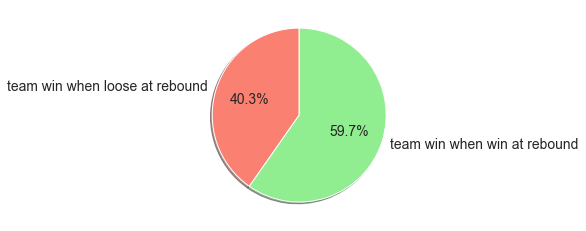

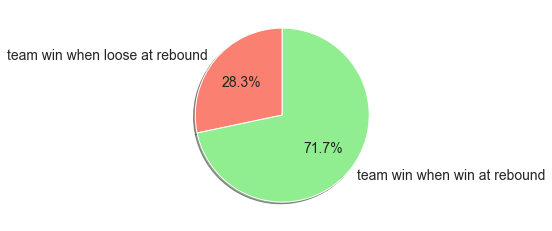

In [54]:
count_column = "DREB_x"
REB_group_columns = ["REB_PCT_DIFF_SIGN","REB_DIFF_SIGN"]
for REB_group_column in REB_group_columns:
    temp_df = ((merge_df[filter_nyk].groupby(REB_group_column)[count_column].count() / games_count).reset_index(name="WIN_PRECENTAGE"))
    temp_df["Reason"] = np.where(temp_df[REB_group_column] == -1 , "team win when loose at rebound","team win when win at rebound")
    ax =temp_df.set_index("Reason").plot.pie(y="WIN_PRECENTAGE",autopct="%1.1f%%", textprops={'fontsize': 14} ,legend=False,shadow=True, startangle=90,colors=["salmon","lightgreen"])
    ax.set_ylabel('')

ABS_REB_PCT_DIFF_GROUP
0.0    0.577994
1.0    0.643357
2.0    0.679245
3.0    1.000000
dtype: float64

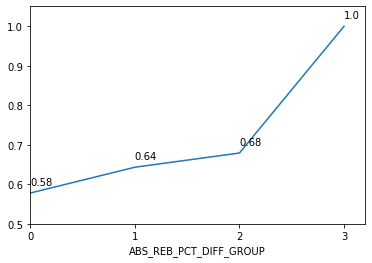

In [9]:
merge_df["ABS_REB_PCT_DIFF_GROUP"] = abs(merge_df["REB_PCT_DIFF_GROUP"])
merge_df["IS_SIGN_POSITIVE"] = np.where(merge_df["REB_PCT_DIFF_SIGN"] == 1 , 1 , 0)
plot_df = (merge_df.groupby("ABS_REB_PCT_DIFF_GROUP")["IS_SIGN_POSITIVE"].sum() / merge_df.groupby("ABS_REB_PCT_DIFF_GROUP")["REB_PCT_DIFF_SIGN"].count())

ax = plot_df.plot(xticks=[0,1,2,3])
ax.set_xlim(0,3.2)
ax.set_ylim(0.5,1.05)
for row in plot_df.items():
     ax.annotate(round(row[1],2), xy=(row[0], row[1] + 0.02))

plot_df

In [40]:
merge_df["color"] = np.where(merge_df["TEAM_ABBREVIATION_x"].isin(["NYK","CLE"]), 'red', 'black')
merge_df["color"] = np.where(merge_df["TEAM_ABBREVIATION_x"].isin(["MIL"]), 'green', merge_df["color"])
df = round(merge_df.groupby(["TEAM_ABBREVIATION_x"]).median().sort_values(["REB_PCT_DIFF"])["REB_PCT_DIFF"] * 100,2).reset_index()
#df.plot.bar(x="TEAM_ABBREVIATION_x",y="REB_PCT_DIFF",colors=df["color"])

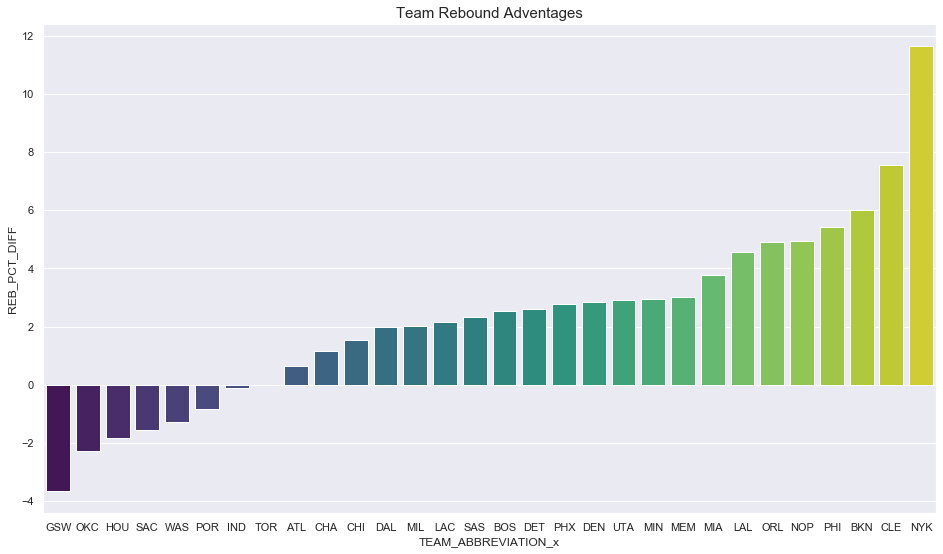

In [46]:
# Import matplotlib
import matplotlib.pyplot as plt

# Import seaborn
import seaborn as sns

# Set dark grid
sns.set()

# Convert index of countries to series for plotting
y_vals = df['REB_PCT_DIFF']

# Select 'Confirmed' column as y-values
x_vals = df["TEAM_ABBREVIATION_x"]

# Set size of figure
plt.figure(figsize=(16,9))

# Create horizontal bar plot
sns.barplot(x=x_vals, y=y_vals, palette='viridis')

# Title plot
plt.title('Team Rebound Adventages', size=15)

# Save figure
#plt.savefig('Coronavirus Recoveries through May 7, 2020', dpi=300)

# Show plot
plt.show()

,REB_PCT_DIFF,REB_PCT_DIFF_GROUP
74,-0.250591,-3.0
206,-0.210252,-3.0
979,-0.208965,-3.0
381,-0.214865,-3.0
133,-0.206829,-3.0
880,-0.213287,-3.0
452,-0.207219,-3.0
983,-0.217174,-3.0
987,-0.201754,-3.0
144,-0.259550,-3.0


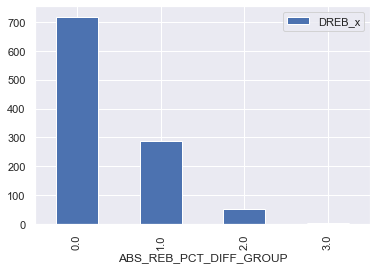

In [60]:
merge_df.groupby(["ABS_REB_PCT_DIFF_GROUP"])["DREB_x"].count().reset_index().plot.bar("ABS_REB_PCT_DIFF_GROUP","DREB_x")